<a href="https://colab.research.google.com/github/EliTirman/Pra3024_2023/blob/main/gw_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 161.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 174.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 249.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 153.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 166.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 289.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import highpass, match
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd
import pycbc.psd
from pycbc.psd import interpolate, aLIGOZeroDetHighPower



Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral
density (PSD) of that data. Test whether there is any gravitational wave signal present
in the data or not? For this test, you can assume the GW signals can produce only
from equal mass binary systems with a range between 5 to 10. We assume a threshold
on matched filter SNR of 8 to claim detection of GW.

In [ ]:
# Loading the data
d = np.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy') 
time = d[:, 0] 
strain = d[:, 1] 

In [ ]:
import pycbc.types  
dt = time[1] - time[0] 
data = pycbc.types.TimeSeries(d[:, 1], delta_t = dt) 

In [ ]:
# creating arrays of data
strain, stilde = {}, {}
# downsample and apply highpass filter
strain = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)
# crop
strain = strain.crop(4, 4)
# create the frequancy domain
stilde = strain.to_frequencyseries()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


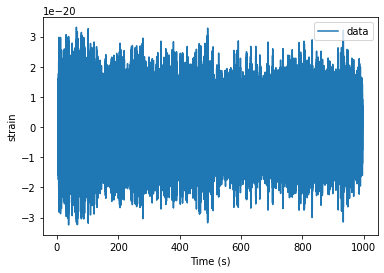

In [ ]:
pylab.plot(strain.sample_times, strain, label= 'data')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

(1e-47, 1e-42)

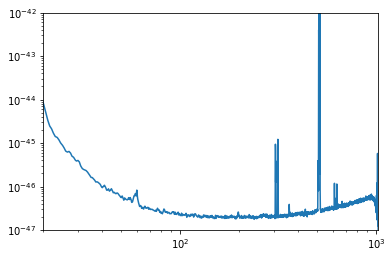

In [ ]:
# calculate and plot the powes spectral density function
psds = {}
delta_t = strain.delta_t
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)
psds = pycbc.psd.welch(strain, seg_len=seg_len, seg_stride=seg_stride)
psds = interpolate(psds, stilde.delta_f)
pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)

In [ ]:
mass1 = np.arange(5, 10, 0.5 ) #mass range bewteen 30 to 40 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning

    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=15.0)

    # We will resize the vector to match our data
    hp.resize(len(strain))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain,
                     psd=psds, low_frequency_cutoff=15.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seconds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr)))
snrs = Snr_list


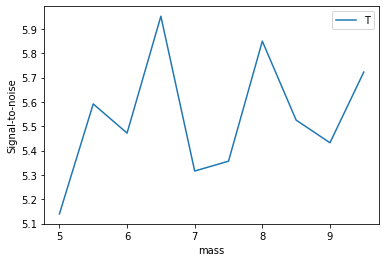

In [ ]:
# plot the signal to noise ratio
pylab.figure()
pylab.plot(mass1, snrs)
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

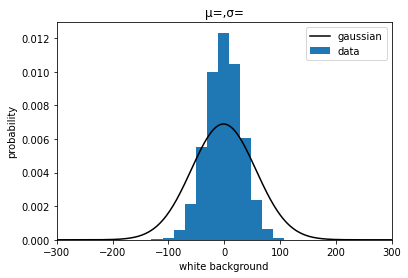

In [ ]:
white_data = (strain.to_frequencyseries() / psds**0.5).to_timeseries()
white_data=white_data.crop(4,4)

limits=(-300,300)
#Fitting the data to a normal distribution
mean,sd=norm.fit(white_data)
#creating the gaussian
x=np.linspace(*limits,300)
gauss=norm.pdf(x,mean,sd)
#plotting
pylab.plot(x,gauss,'k',label='Gaussian Fit');
y=pylab.hist(white_data,bins=300,density=True,label='Data')
pylab.xlim(*limits);
pylab.legend();
pylab.title("μ-,σ=".format(mean,sd));
pylab.xlabel("white background");
pylab.ylabel("probability");

The horizon distance of a GW detector is defined as a distance to the source for which
the accumulated signal power (optimal SNR) is equal to a detection threshold of SNR
(ρmin = 8) when the source is located overhead (θ = 0,π). Plot the horizon distance
for Advanced LIGO detector (assuming ’H1’ noise PSD) assuming a set of equal mass
binary with a range of component masses between 5 to 500. In this plot, you can
assume that X-axis and Y-axis represent the total mass of the binary and horizon
distance, respectively. For this analysis, first, generate the GW waves polarization in
frequency domain, h+(f),h×(f) and construct the projection detector frame, h(f) =
F+h+(f) + F×h×(f), where F+ and F×are the antenna pattern functions for the two
polarizations. Using the sky location (θ,φ) and polarization angle of the incoming GW,
one can show that for ‘L’ shaped detector F+,F×can be written as


In [ ]:
from pycbc.filter import sigmasq 
SNR = (pycbc.filter.sigmasq(hp, psd))**0.5 
